**Graphs of the dataset**

In [5]:

import pandas as pd
import numpy as np
import seaborn as s
import json
dataset_path = "../../compiled_coffee_level_annotations.json"

with open(dataset_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# convert the list of annotation dicts to a DataFrame
dataset = pd.json_normalize(data["annotation_data"])


                                            filename  coffee_level  \
0  left_flipped_masked_photo_2018-01-16_10-18-27.jpg            10   
1  left_flipped_masked_photo_2018-01-16_11-34-00.jpg             0   
2  left_flipped_masked_photo_2018-01-16_12-25-28.jpg             0   
3  left_flipped_masked_photo_2018-01-16_13-27-14.jpg             0   
4  left_flipped_masked_photo_2018-01-16_20-08-40.jpg             0   

                    timestamp annotator version  
0  2025-09-19T13:26:14.199578    manual     1.0  
1  2025-09-19T13:26:14.166264    manual     1.0  
2  2025-09-19T13:31:33.837350    manual     1.0  
3  2025-09-26T10:56:41.845400    manual     1.0  
4  2025-09-26T10:56:41.845400    manual     1.0  


coffee_level counts:
coffee_level
0     756
1      96
2      80
3      72
4      54
5      31
6      25
7      27
8      33
9      21
10      5


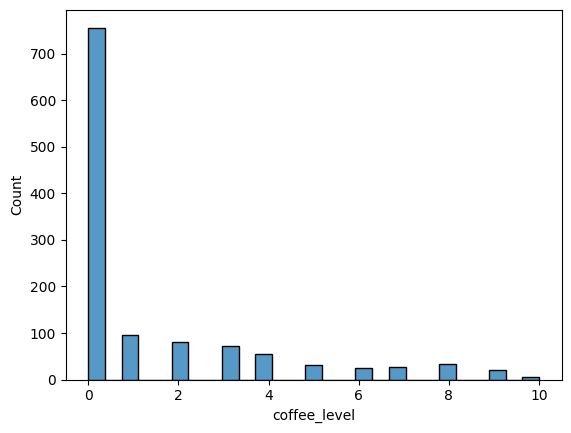

In [8]:
y_label = dataset["coffee_level"]

s.histplot(y_label)

counts = y_label.value_counts().sort_index()
total = counts.sum()

print("coffee_level counts:")
print(counts.to_string())

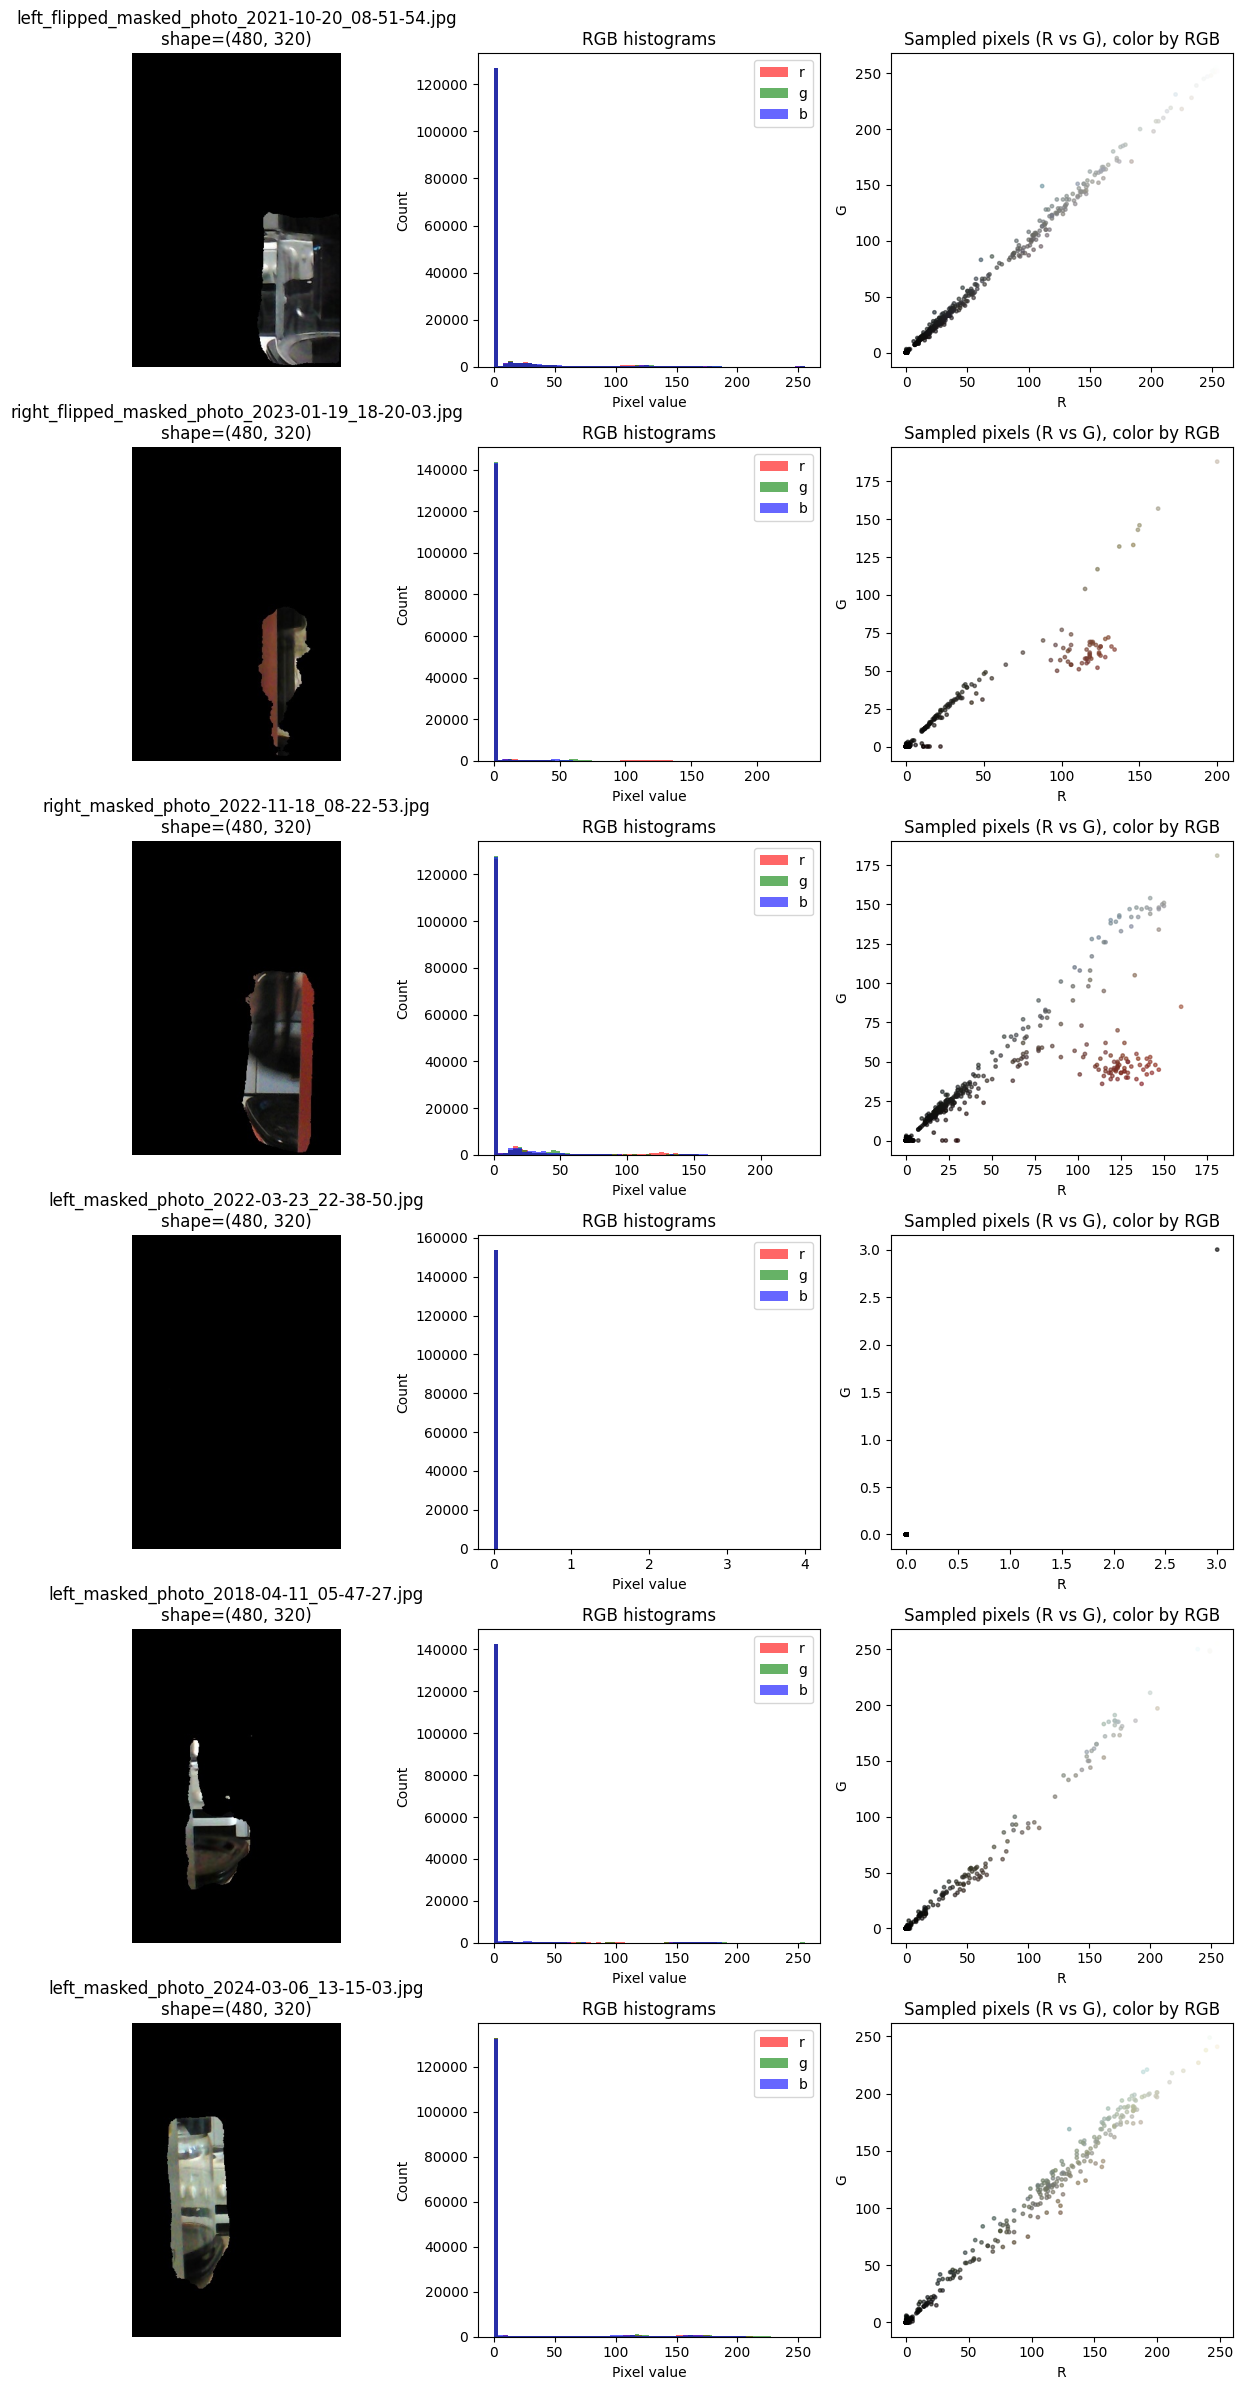

coffee_level counts:
coffee_level
0     756
1      96
2      80
3      72
4      54
5      31
6      25
7      27
8      33
9      21
10      5

Global mean color (R,G,B): [10.5, 10.4, 10.0]  std: [5.8, 5.6, 5.1]


In [9]:
# ...existing code...
import os
import random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# locate images directory (adjust if your images live elsewhere)
possible_dirs = [
    os.path.join(os.path.dirname(dataset_path), "processed_images"),
    os.path.join(os.path.dirname(dataset_path), "../processed_images"),
    "../../processed_images",
    "./processed_images",
]
images_dir = next((d for d in possible_dirs if d and os.path.exists(os.path.normpath(d))), None)
if images_dir is None:
    raise FileNotFoundError("Could not find masked/processed images directory. Update possible_dirs or set images_dir manually.")

# sample filenames from dataset (ensure they exist)
filenames = dataset["filename"].dropna().unique().tolist()
filenames = [f for f in filenames if os.path.exists(os.path.join(images_dir, f))]
if not filenames:
    raise FileNotFoundError(f"No filenames from dataset found in {images_dir}")

n_display = min(6, len(filenames))
sample_files = random.sample(filenames, n_display)

# plot thumbnails and basic color stats
fig, axes = plt.subplots(n_display, 3, figsize=(12, 4 * n_display))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(images_dir, fname)
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Failed to read image: {img_path}")
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # thumbnail
    ax_img = axes[i, 0]
    ax_img.imshow(img)
    ax_img.axis("off")
    ax_img.set_title(f"{fname}\nshape={img.shape[:2]}")

    # per-channel histogram
    ax_hist = axes[i, 1]
    colors = ("r", "g", "b")
    for c, col in enumerate(colors):
        ax_hist.hist(img[:, :, c].ravel(), bins=64, color=col, alpha=0.6, label=col)
    ax_hist.set_xlabel("Pixel value")
    ax_hist.set_ylabel("Count")
    ax_hist.legend()
    ax_hist.set_title("RGB histograms")

    # sampled-pixel RGB scatter (downsample pixels for speed)
    ax_scatter = axes[i, 2]
    pixels = img.reshape(-1, 3)
    sample_n = min(2000, pixels.shape[0])
    pix_sample = pixels[np.random.choice(pixels.shape[0], sample_n, replace=False)]
    # scatter in 3 channels by plotting R vs G colored by B
    ax_scatter.scatter(pix_sample[:, 0], pix_sample[:, 1], c=pix_sample / 255.0, s=6, alpha=0.6)
    ax_scatter.set_xlabel("R")
    ax_scatter.set_ylabel("G")
    ax_scatter.set_title("Sampled pixels (R vs G), color by RGB")

plt.tight_layout()
plt.show()

# summary across dataset: counts per coffee_level (text) and overall color mean/std
levels = dataset["coffee_level"].value_counts().sort_index()
print("coffee_level counts:")
print(levels.to_string())

# compute global mean color from available image files (sample subset for speed)
sample_files_all = random.sample(filenames, min(30, len(filenames)))
means = []
for fname in sample_files_all:
    p = os.path.join(images_dir, fname)
    bgr = cv2.imread(p, cv2.IMREAD_COLOR)
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    means.append(rgb.mean(axis=(0, 1)))
if means:
    means = np.vstack(means)
    mean_color = means.mean(axis=0)
    std_color = means.std(axis=0)
    print(f"\nGlobal mean color (R,G,B): {mean_color.round(1).tolist()}  std: {std_color.round(1).tolist()}")
# ...existing code...

Prepared 1200 labeled images for correlation analysis.

Correlation summary:
 Pearson: mean_R vs coffee_level = 0.000
 Pearson: mean_G vs coffee_level = -0.034
 Pearson: mean_gray vs coffee_level = -0.024
 Spearman: mean_R vs coffee_level = 0.055
 Spearman: mean_G vs coffee_level = 0.026
 Spearman: mean_gray vs coffee_level = 0.031
 Pearson: (R-G) vs coffee_level = 0.162


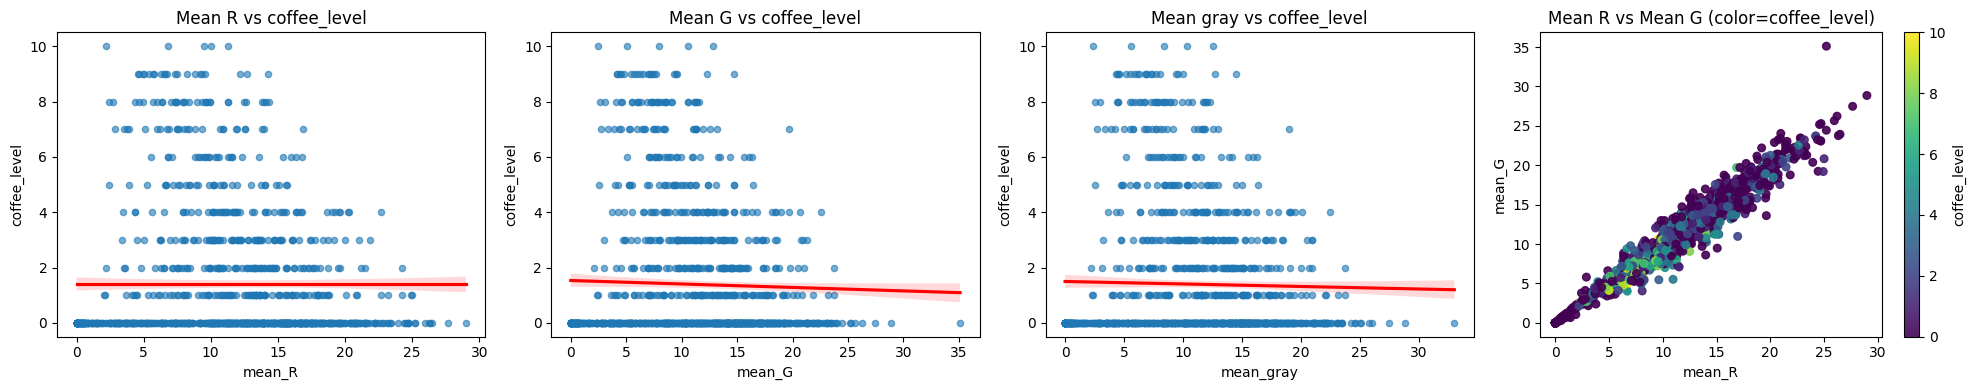

In [11]:
# Correlation analysis between per-image mean R/G/B/gray and coffee_level
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Build per-image mean color DataFrame (add grayscale mean)
means_list = []
for fname in filenames:
    p = os.path.join(images_dir, fname)
    bgr = cv2.imread(p, cv2.IMREAD_COLOR)
    if bgr is None:
        continue
    # RGB means
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    mean_rgb = rgb.mean(axis=(0, 1))
    # Grayscale mean (use the same image converted to gray)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    mean_gray = float(gray.mean())

    means_list.append({
        "filename": fname,
        "mean_R": float(mean_rgb[0]),
        "mean_G": float(mean_rgb[1]),
        "mean_B": float(mean_rgb[2]),
        "mean_gray": mean_gray,
    })

if not means_list:
    print("No images available for correlation analysis.")
else:
    color_df = pd.DataFrame(means_list)
    # merge with dataset labels
    merged = color_df.merge(dataset[["filename", "coffee_level"]], on="filename", how="left")
    merged = merged.dropna(subset=["coffee_level"]).copy()
    if merged.empty:
        print("No labeled images found after merging with dataset.")
    else:
        merged["coffee_level"] = merged["coffee_level"].astype(float)
        print(f"Prepared {len(merged)} labeled images for correlation analysis.")

        # correlations (Pearson & Spearman)
        pearson_R = merged["mean_R"].corr(merged["coffee_level"], method="pearson")
        pearson_G = merged["mean_G"].corr(merged["coffee_level"], method="pearson")
        pearson_gray = merged["mean_gray"].corr(merged["coffee_level"], method="pearson")
        spearman_R = merged["mean_R"].corr(merged["coffee_level"], method="spearman")
        spearman_G = merged["mean_G"].corr(merged["coffee_level"], method="spearman")
        spearman_gray = merged["mean_gray"].corr(merged["coffee_level"], method="spearman")
        rg_diff_corr = (merged["mean_R"] - merged["mean_G"]).corr(merged["coffee_level"], method="pearson")

        print("\nCorrelation summary:")
        print(f" Pearson: mean_R vs coffee_level = {pearson_R:.3f}")
        print(f" Pearson: mean_G vs coffee_level = {pearson_G:.3f}")
        print(f" Pearson: mean_gray vs coffee_level = {pearson_gray:.3f}")
        print(f" Spearman: mean_R vs coffee_level = {spearman_R:.3f}")
        print(f" Spearman: mean_G vs coffee_level = {spearman_G:.3f}")
        print(f" Spearman: mean_gray vs coffee_level = {spearman_gray:.3f}")
        print(f" Pearson: (R-G) vs coffee_level = {rg_diff_corr:.3f}")

        # Plots: mean_R, mean_G, mean_gray vs label + mean_R vs mean_G colored by label
        fig, axes = plt.subplots(1, 4, figsize=(20, 4))
        sns.regplot(x="mean_R", y="coffee_level", data=merged, ax=axes[0], scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"color": "red"})
        axes[0].set_title("Mean R vs coffee_level")

        sns.regplot(x="mean_G", y="coffee_level", data=merged, ax=axes[1], scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"color": "red"})
        axes[1].set_title("Mean G vs coffee_level")

        sns.regplot(x="mean_gray", y="coffee_level", data=merged, ax=axes[2], scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"color": "red"})
        axes[2].set_title("Mean gray vs coffee_level")

        sc = axes[3].scatter(merged["mean_R"], merged["mean_G"], c=merged["coffee_level"], cmap="viridis", s=30, alpha=0.9)
        axes[3].set_xlabel("mean_R")
        axes[3].set_ylabel("mean_G")
        axes[3].set_title("Mean R vs Mean G (color=coffee_level)")
        cbar = fig.colorbar(sc, ax=axes[3])
        cbar.set_label("coffee_level")

        plt.tight_layout()
        plt.show()

In [12]:
# Feature extractor: Color moments (mean, std, skew) per channel
import numpy as np

def color_moments(img_rgb, mask=None):
    """Compute mean, std, skew for each RGB channel.

    img_rgb: HxWx3 RGB uint8 or float image
    mask: optional HxW boolean mask (True for ROI)
    returns: 9-d numpy array [R_mean,R_std,R_skew, G_mean,...]
    """
    arr = img_rgb.astype(float)
    if mask is not None:
        mask = np.asarray(mask).astype(bool)
        if mask.shape != arr.shape[:2]:
            raise ValueError("mask must match image spatial dims")
        pixels = arr[mask]
    else:
        pixels = arr.reshape(-1, 3)
    moments = []
    for c in range(3):
        ch = pixels[:, c]
        mu = ch.mean() if ch.size else 0.0
        std = ch.std(ddof=0) if ch.size else 0.0
        # skew: safe compute (fallback if std==0)
        if ch.size and std > 1e-8:
            skew = float(((ch - mu) ** 3).mean() / (std ** 3))
        else:
            skew = 0.0
        moments.extend([float(mu), float(std), float(skew)])
    return np.array(moments, dtype=float)

# quick usage example (uncomment to run in notebook):
img = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2RGB)
print(color_moments(img))


[11.2983724  38.24492031  3.83525705 12.7925651  42.18083765  3.67494854
 14.09910156 45.12243093  3.49240686]


In [16]:
# Feature extractor: Color histograms (per-channel)
import numpy as np

def color_histograms(img_rgb, bins_per_channel=32, mask=None, hist_range=(0, 256)):
    """Compute normalized per-channel histograms concatenated into a vector.

    Returns length 3*bins_per_channel vector.
    """
    arr = img_rgb.astype(np.uint8)
    if mask is not None:
        mask = np.asarray(mask).astype(bool)
        pixels = arr[mask]
    else:
        pixels = arr.reshape(-1, 3)
    feats = []
    for c in range(3):
        h, _ = np.histogram(pixels[:, c], bins=bins_per_channel, range=hist_range)
        if h.sum() > 0:
            h = h.astype(float) / h.sum()
        feats.extend(h.tolist())
    return np.array(feats, dtype=float)

# Example:
img = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2RGB)
print(color_histograms(img, bins_per_channel=32).shape)


(96,)


In [17]:
# Feature extractor: Vertical intensity profile (domain-specific)
import numpy as np

def vertical_profile(img_gray, mask=None, n_bins=64, use_mask_crop=True):
    """Compute a downsampled vertical profile from top to bottom.

    If mask provided and use_mask_crop True, profile is computed over the mask's bounding box vertical span.
    """
    H, W = img_gray.shape[:2]
    if mask is not None and use_mask_crop:
        ys, xs = np.where(np.asarray(mask).astype(bool))
        if len(ys) == 0:
            # fallback to full image
            row_mean = img_gray.mean(axis=1)
        else:
            y0, y1 = ys.min(), ys.max()
            crop = img_gray[y0:y1+1]
            row_mean = crop.mean(axis=1)
            # map to full vertical axis for interpretability
            # we'll interpolate across the crop height
            H_crop = crop.shape[0]
            row_mean = np.interp(np.linspace(0, H_crop-1, H), np.arange(H_crop), row_mean)
    else:
        row_mean = img_gray.mean(axis=1)
    # downsample/interpolate to n_bins
    y = np.arange(len(row_mean))
    x_new = np.linspace(0, len(row_mean)-1, n_bins)
    profile = np.interp(x_new, y, row_mean)
    # normalize
    if profile.max() - profile.min() > 0:
        profile = (profile - profile.mean()) / (profile.std() + 1e-9)
    return profile.astype(float)

# Example usage:
gray = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2GRAY)
print(vertical_profile(gray, n_bins=64).shape)


(64,)


In [18]:
# Feature extractor: HOG (Histogram of Oriented Gradients)
from skimage.feature import hog
from skimage.color import rgb2gray

def hog_features(img_rgb, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    """Return HOG feature vector for RGB image (computed on grayscale).

    Requires scikit-image.
    """
    gray = rgb2gray(img_rgb)
    feat = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=False, feature_vector=True)
    return feat.astype(float)

# Example:
img = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2RGB)
print(hog_features(img).shape)


(19836,)


In [22]:
# Feature extractor: GLCM / Haralick-like features
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def glcm_features(img_gray, distances=(1, 2, 4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4), levels=256):
    """Compute averaged GLCM properties: contrast, dissimilarity, homogeneity, energy, correlation, ASM"""
    img = img_gray
    if img.dtype != np.uint8:
        img = (255 * (img / img.max())).astype(np.uint8) if img.max() > 0 else img.astype(np.uint8)
    if levels != 256:
        img = (img.astype(np.float32) / 256 * levels).astype(np.uint8)
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)
        feats.append(float(np.nanmean(vals)))
    return np.array(feats, dtype=float)

# Example:
gray = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2GRAY)
print(glcm_features(gray))


[254.21495576   2.68692405   0.87180024   0.82305196   0.92609373
   0.67742064]


In [23]:
# Feature extractor: LBP (Local Binary Patterns) histogram
from skimage.feature import local_binary_pattern
import numpy as np

def lbp_histogram(img_gray, P=8, R=1, method='uniform', n_bins=None):
    """Compute LBP and return a normalized histogram."""
    lbp = local_binary_pattern(img_gray, P, R, method)
    if n_bins is None:
        n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    if hist.sum() > 0:
        hist = hist.astype(float) / hist.sum()
    return hist.astype(float)

# Example:
gray = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2GRAY)
print(lbp_histogram(gray, P=8, R=1).shape)


(10,)


In [25]:
# Feature extractor: Gabor filter bank responses (mean & std per filter)
import numpy as np
import cv2

def gabor_bank_features(img_gray, frequencies=(0.1, 0.2, 0.3), thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4), ksize=31):
    feats = []
    for theta in thetas:
        for freq in frequencies:
            sigma = 4.0
            lam = 1.0 / (freq if freq > 0 else 0.1)
            gamma = 0.5
            psi = 0
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lam, gamma, psi, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(img_gray.astype(np.float32), cv2.CV_32F, kern)
            feats.append(float(filtered.mean()))
            feats.append(float(filtered.std()))
    return np.array(feats, dtype=float)

# Example:
gray = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2GRAY)
print(gabor_bank_features(gray).shape)


(24,)


In [26]:
# Feature extractor: FFT radial band energies
import numpy as np

def fft_band_features(img_gray, n_bands=8):
    """Compute normalized energy per radial frequency band from FFT magnitude."""
    arr = img_gray.astype(float)
    f = np.fft.fft2(arr)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    h, w = mag.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((Y - cy) ** 2 + (X - cx) ** 2)
    maxr = R.max()
    bands = np.linspace(0, maxr, n_bands + 1)
    total = mag.sum() + 1e-12
    feats = []
    for i in range(n_bands):
        mask = (R >= bands[i]) & (R < bands[i+1])
        val = mag[mask].sum()
        feats.append(float(val / total))
    return np.array(feats, dtype=float)

# Example:
gray = cv2.cvtColor(cv2.imread(os.path.join(images_dir, filenames[0])), cv2.COLOR_BGR2GRAY)
print(fft_band_features(gray))


[0.33594824 0.18293771 0.13691202 0.12401973 0.10228158 0.06148024
 0.0463074  0.01011217]


In [27]:
# Runner cell: apply all extractors and build a feature matrix
import pandas as pd
import numpy as np

extractors = {
    'color_moments': lambda rgb, gray, mask=None: color_moments(rgb, mask=mask),
    'color_hist': lambda rgb, gray, mask=None: color_histograms(rgb, bins_per_channel=32, mask=mask),
    'vertical_profile': lambda rgb, gray, mask=None: vertical_profile(gray, mask=mask, n_bins=64),
    'hog': lambda rgb, gray, mask=None: hog_features(rgb),
    'glcm': lambda rgb, gray, mask=None: glcm_features(gray),
    'lbp': lambda rgb, gray, mask=None: lbp_histogram(gray, P=8, R=1, method='uniform', n_bins=59),
    'gabor': lambda rgb, gray, mask=None: gabor_bank_features(gray),
    'fft_bands': lambda rgb, gray, mask=None: fft_band_features(gray, n_bands=8),
}

# iterate filenames (use a small subset for speed during experiments)
sample = filenames if len(filenames) <= 200 else random.sample(filenames, 200)
rows = []
skipped = 0
for fname in sample:
    p = os.path.join(images_dir, fname)
    bgr = cv2.imread(p, cv2.IMREAD_COLOR)
    if bgr is None:
        skipped += 1
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    row = {'filename': fname}
    ok = True
    for name, fn in extractors.items():
        try:
            feats = fn(rgb, gray, None)
            feats = np.asarray(feats).ravel()
            for i, v in enumerate(feats):
                row[f"{name}_{i}"] = float(v)
        except Exception as e:
            print(f"Extractor {name} failed for {fname}: {e}")
            ok = False
            break
    if ok:
        # attach label if available
        lbl = dataset.loc[dataset['filename'] == fname, 'coffee_level']
        row['coffee_level'] = float(lbl.iloc[0]) if not lbl.empty else np.nan
        rows.append(row)

feature_df = pd.DataFrame(rows)
print(f"Built feature matrix: {feature_df.shape[0]} samples x {feature_df.shape[1]-2} features (plus filename & coffee_level). Skipped {skipped} files.")
# show a small sample
feature_df.head()

# Optionally save
# feature_df.to_csv('features_extracted_sample.csv', index=False)


Built feature matrix: 200 samples x 20102 features (plus filename & coffee_level). Skipped 0 files.


filename  color_moments_0  \
0  right_flipped_masked_photo_2024-03-21_08-50-49...         8.232272   
1  right_flipped_masked_photo_2018-01-19_10-00-40...        10.934473   
2         right_masked_photo_2018-01-26_06-56-24.jpg        12.026471   
3  left_flipped_masked_photo_2021-11-02_07-44-26.jpg        14.874714   
4         right_masked_photo_2024-01-11_13-18-35.jpg        18.354915   

   color_moments_1  color_moments_2  color_moments_3  color_moments_4  \
0        30.261860         4.340880         8.734154        32.251309   
1        39.602773         4.214500         8.507910        31.697368   
2        36.879854         3.484359        10.434089        32.434370   
3        39.272448         2.779653        14.737832        39.466514   
4        45.664853         2.593940        14.629590        37.954505   

   color_moments_5  color_moments_6  color_moments_7  color_moments_8  ...  \
0         4.385788         8.673776        32.334836         4.480699  ...   
1         5.098646         7.845273        29.805589         5.363157  ...   
2         3.952487         9.921797        31.111835         4.061762  ...   
3         3.039005        17.347852        46.606859         3.020506  ...   
4         2.983942        11.676608        32.038501         3.345976  ...   

    gabor_23  fft_bands_0  fft_bands_1  fft_bands_2  fft_bands_3  fft_bands_4  \
0  20.812040     0.339495     0.170538     0.136735     0.123434     0.103382   
1  27.345415     0.336589     0.200067     0.141634     0.113886     0.089929   
2  46.226643     0.308957     0.188189     0.142749     0.121387     0.101266   
3  29.420795     0.319808     0.181866     0.137247     0.123642     0.104150   
4  38.107147     0.316126     0.184345     0.146341     0.129797     0.100594   

   fft_bands_5  fft_bands_6  fft_bands_7  coffee_level  
0     0.064825     0.050718     0.010872           0.0  
1     0.062103     0.046821     0.008970           7.0  
2     0.067775     0.055872     0.013803           3.0  
3     0.066679     0.053999     0.012606           2.0  
4     0.062838     0.047892     0.012066           0.0  

[5 rows x 20104 columns]

C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_30756\600737522.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_p.index, y=top_p['pearson'], palette='vlag')


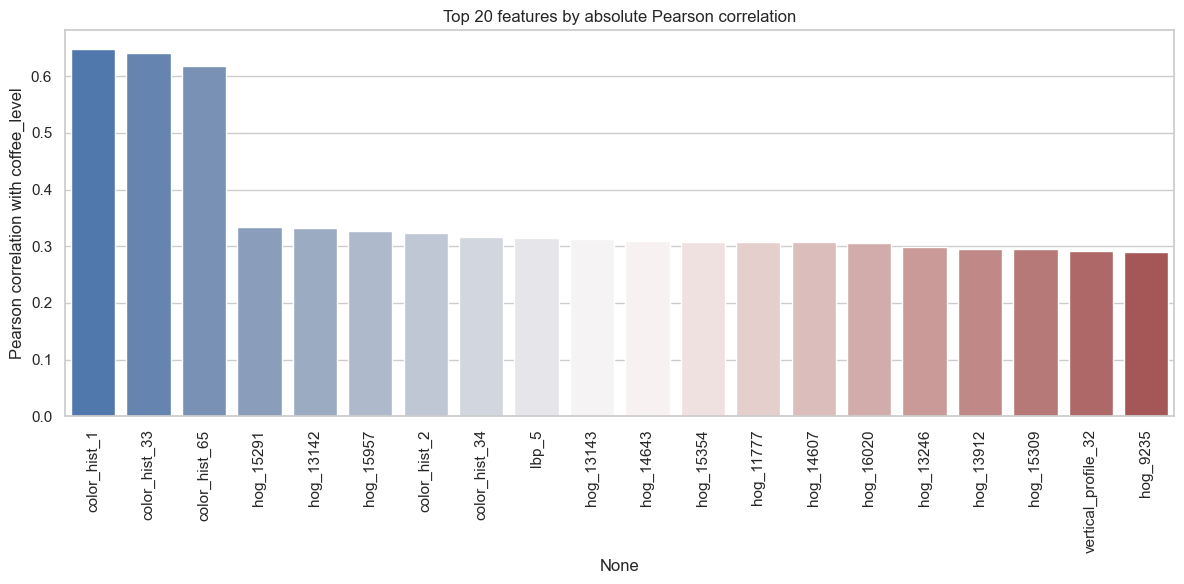

C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_30756\600737522.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_s.index, y=top_s['spearman'], palette='vlag')


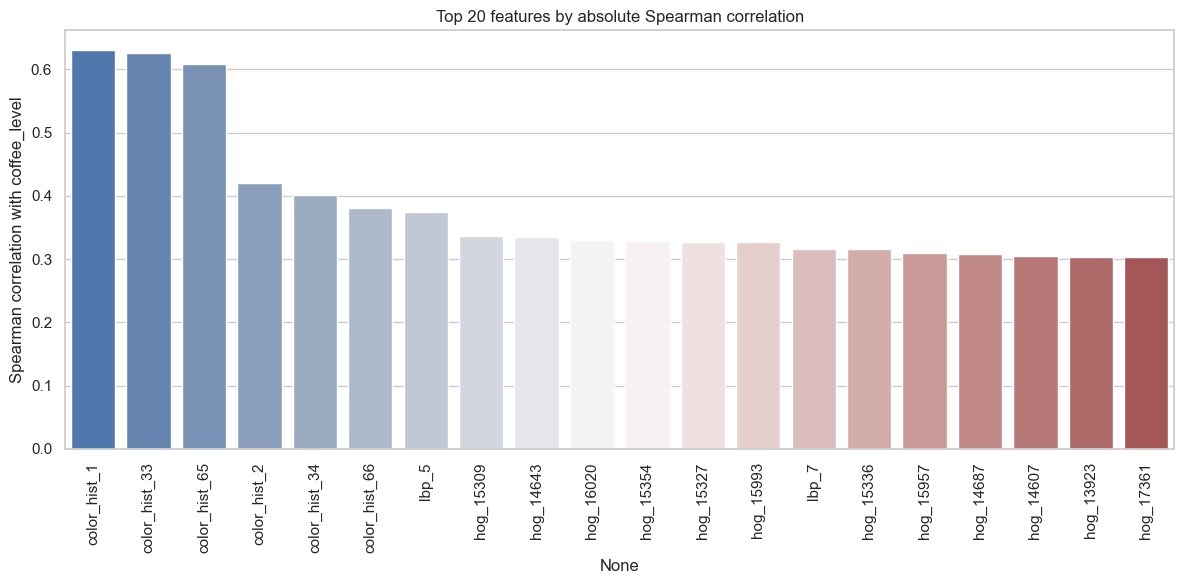

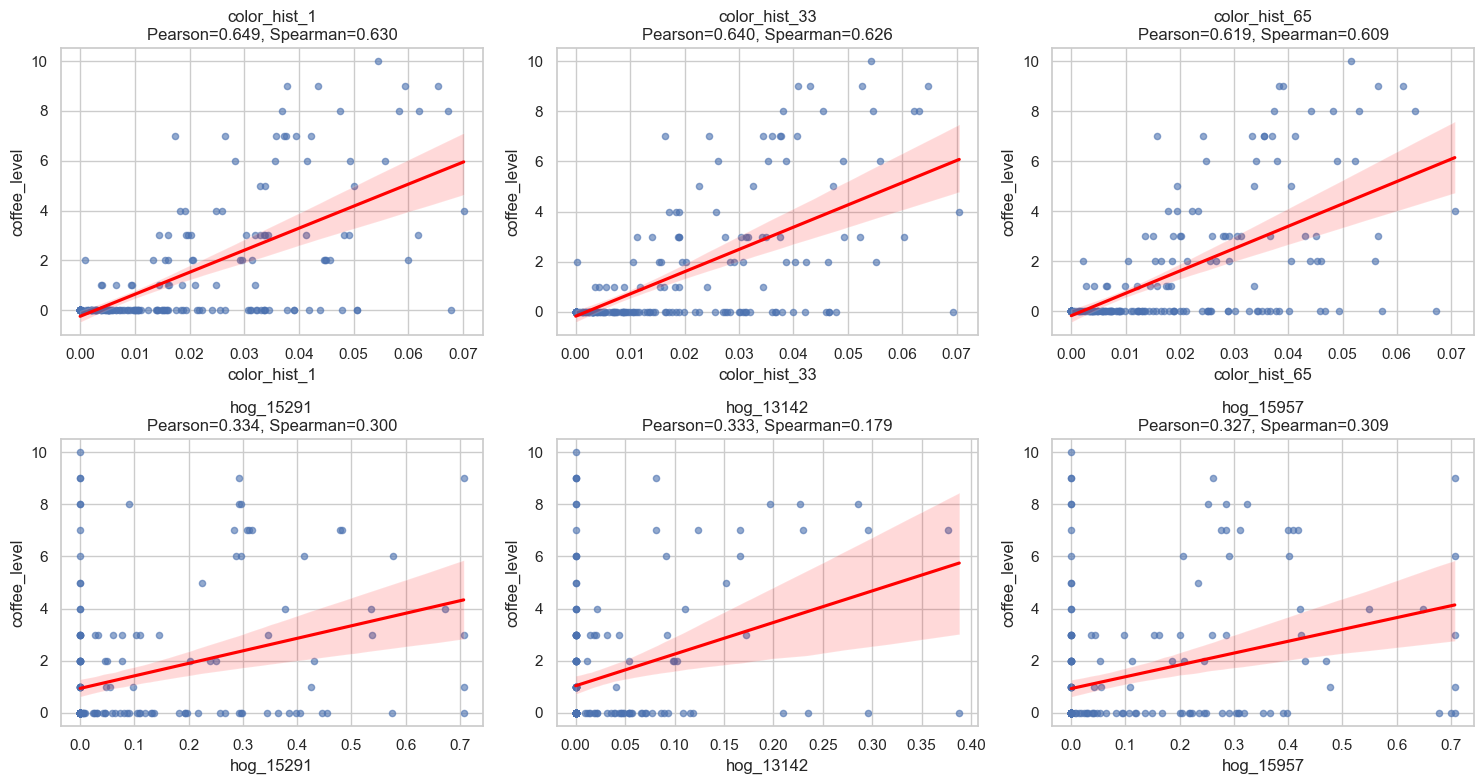


Top 50 features by absolute Pearson correlation:


pearson  spearman  abs_pearson  abs_spearman
color_hist_1         0.648542  0.630078     0.648542      0.630078
color_hist_33        0.640370  0.625607     0.640370      0.625607
color_hist_65        0.619018  0.609076     0.619018      0.609076
hog_15291            0.334090  0.300053     0.334090      0.300053
hog_13142            0.333053  0.179447     0.333053      0.179447
hog_15957            0.327099  0.309096     0.327099      0.309096
color_hist_2         0.322762  0.420146     0.322762      0.420146
color_hist_34        0.315906  0.401555     0.315906      0.401555
lbp_5                0.315207  0.375167     0.315207      0.375167
hog_13143            0.312127  0.168776     0.312127      0.168776
hog_14643            0.308642  0.335804     0.308642      0.335804
hog_15354            0.307344  0.329379     0.307344      0.329379
hog_11777            0.307087  0.141005     0.307087      0.141005
hog_14607            0.306895  0.304587     0.306895      0.304587
hog_16020            0.305704  0.330621     0.305704      0.330621
hog_13246            0.299343  0.253706     0.299343      0.253706
hog_13912            0.294949  0.262447     0.294949      0.262447
hog_15309            0.294796  0.337106     0.294796      0.337106
vertical_profile_32  0.291633  0.283298     0.291633      0.283298
hog_9235             0.289797  0.219373     0.289797      0.219373
hog_13976            0.287799  0.277653     0.287799      0.277653
hog_17640            0.287102  0.244153     0.287102      0.244153
hog_11750            0.285561  0.132925     0.285561      0.132925
hog_11813            0.284346  0.104898     0.284346      0.104898
vertical_profile_33  0.284271  0.267517     0.284271      0.267517
hog_16262            0.283611  0.241853     0.283611      0.241853
hog_11714            0.282961  0.169063     0.282961      0.169063
hog_11829            0.282918  0.106770     0.282918      0.106770
vertical_profile_34  0.281359  0.283422     0.281359      0.283422
hog_15273            0.281020  0.293287     0.281020      0.293287
hog_14714            0.280688  0.293930     0.280688      0.293930
hog_13807            0.280535  0.135716     0.280535      0.135716
hog_13923            0.280013  0.304008     0.280013      0.304008
hog_13590            0.279979  0.187037     0.279979      0.187037
hog_17388            0.279512  0.274822     0.279512      0.274822
hog_13986            0.279138  0.281013     0.279138      0.281013
hog_16974            0.278109  0.243779     0.278109      0.243779
hog_13776            0.277540  0.129686     0.277540      0.129686
hog_13302            0.277417  0.283019     0.277417      0.283019
hog_14652            0.277345  0.285765     0.277345      0.285765
hog_11111            0.275822  0.136989     0.275822      0.136989
hog_14589            0.274738  0.299888     0.274738      0.299888
hog_13310            0.274574  0.271654     0.274574      0.271654
hog_12459            0.274324  0.158131     0.274324      0.158131
hog_4242             0.271495  0.205334     0.271495      0.205334
hog_8496             0.271357  0.226243     0.271357      0.226243
hog_13141            0.271154  0.152583     0.271154      0.152583
hog_7997             0.269608  0.112913     0.269608      0.112913
hog_13147            0.268991  0.171146     0.268991      0.171146
hog_17603            0.268936  0.236477     0.268936      0.236477

In [28]:
# Correlation analysis between extracted features and coffee_level
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Ensure feature_df exists (runner cell should have created it)
if 'feature_df' not in globals():
    csv_path = 'features_extracted_sample.csv'
    if os.path.exists(csv_path):
        feature_df = pd.read_csv(csv_path)
        print(f"Loaded feature_df from {csv_path}")
    else:
        raise NameError("feature_df not found in environment. Run the runner cell that builds the feature matrix first.")

if 'coffee_level' not in feature_df.columns:
    raise KeyError("feature_df must contain a 'coffee_level' column")

# select numeric feature columns (exclude filename and coffee_level)
num_df = feature_df.select_dtypes(include=[np.number]).copy()
if 'coffee_level' not in num_df.columns:
    num_df['coffee_level'] = feature_df['coffee_level'].astype(float)

feature_cols = [c for c in num_df.columns if c != 'coffee_level']
if not feature_cols:
    raise ValueError('No numeric features found in feature_df')

# compute Pearson and Spearman correlations
pearson = num_df[feature_cols + ['coffee_level']].corr(method='pearson')['coffee_level'].loc[feature_cols]
spearman = num_df[feature_cols + ['coffee_level']].corr(method='spearman')['coffee_level'].loc[feature_cols]

corr_df = pd.DataFrame({'pearson': pearson, 'spearman': spearman})
corr_df['abs_pearson'] = corr_df['pearson'].abs()
corr_df['abs_spearman'] = corr_df['spearman'].abs()

# plotting settings
sns.set_theme(style='whitegrid')
TOP_N = 20

# Top features by absolute Pearson
top_p = corr_df.sort_values('abs_pearson', ascending=False).head(TOP_N)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_p.index, y=top_p['pearson'], palette='vlag')
plt.xticks(rotation=90)
plt.ylabel('Pearson correlation with coffee_level')
plt.title(f'Top {TOP_N} features by absolute Pearson correlation')
plt.tight_layout()
plt.show()

# Top features by absolute Spearman
top_s = corr_df.sort_values('abs_spearman', ascending=False).head(TOP_N)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_s.index, y=top_s['spearman'], palette='vlag')
plt.xticks(rotation=90)
plt.ylabel('Spearman correlation with coffee_level')
plt.title(f'Top {TOP_N} features by absolute Spearman correlation')
plt.tight_layout()
plt.show()

# Scatter + regression for top features (by Pearson)
top_feats = corr_df.sort_values('abs_pearson', ascending=False).head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feat in zip(axes.flatten(), top_feats):
    sns.regplot(x=feature_df[feat], y=feature_df['coffee_level'], ax=ax,
                scatter_kws={'s': 20, 'alpha': 0.6}, line_kws={'color': 'red'})
    p = corr_df.loc[feat, 'pearson']
    s = corr_df.loc[feat, 'spearman']
    ax.set_title(f"{feat}\nPearson={p:.3f}, Spearman={s:.3f}")
    ax.set_xlabel(feat)
    ax.set_ylabel('coffee_level')
plt.tight_layout()
plt.show()

# Print a table of top correlations
print('\nTop 50 features by absolute Pearson correlation:')
display(corr_df.sort_values('abs_pearson', ascending=False).head(50))

# Optionally save correlation table
# corr_df.to_csv('feature_correlations.csv')


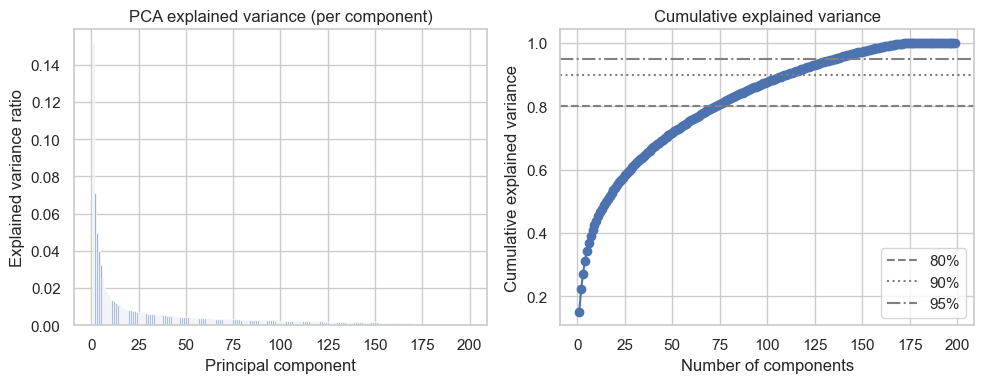

Components to reach 80% explained variance: 73
Components to reach 90% explained variance: 111
Components to reach 95% explained variance: 136


component  explained  cumulative
0           1   0.151381    0.151381
1           2   0.071008    0.222389
2           3   0.049554    0.271943
3           4   0.040003    0.311946
4           5   0.032291    0.344237
5           6   0.025582    0.369819
6           7   0.020174    0.389992
7           8   0.017921    0.407914
8           9   0.015965    0.423878
9          10   0.014300    0.438178
10         11   0.013774    0.451952
11         12   0.012850    0.464802
12         13   0.011817    0.476620
13         14   0.010912    0.487532
14         15   0.010721    0.498253
15         16   0.009995    0.508249
16         17   0.009279    0.517528
17         18   0.008904    0.526432
18         19   0.008624    0.535055
19         20   0.008400    0.543456
20         21   0.008080    0.551536
21         22   0.007867    0.559403
22         23   0.007601    0.567004
23         24   0.007238    0.574241
24         25   0.007156    0.581397
25         26   0.006986    0.588383
26         27   0.006935    0.595318
27         28   0.006497    0.601815
28         29   0.006368    0.608183
29         30   0.006265    0.614448
30         31   0.006072    0.620520
31         32   0.005943    0.626462
32         33   0.005861    0.632323
33         34   0.005722    0.638045
34         35   0.005598    0.643643
35         36   0.005538    0.649181
36         37   0.005433    0.654614
37         38   0.005348    0.659962
38         39   0.005199    0.665161
39         40   0.005138    0.670299
40         41   0.005010    0.675308
41         42   0.004941    0.680249
42         43   0.004747    0.684996
43         44   0.004698    0.689694
44         45   0.004620    0.694314
45         46   0.004556    0.698870
46         47   0.004439    0.703309
47         48   0.004368    0.707677
48         49   0.004308    0.711985
49         50   0.004253    0.716237

In [29]:
# PCA explained variance and cumulative explained variance for extracted features
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load or reuse feature_df from notebook
if 'feature_df' not in globals():
    csv_path = 'features_extracted_sample.csv'
    if os.path.exists(csv_path):
        feature_df = pd.read_csv(csv_path)
        print(f"Loaded feature_df from {csv_path}")
    else:
        raise NameError("feature_df not found in environment. Run the runner cell that builds the feature matrix first.")

# Prepare numeric feature matrix
num_df = feature_df.select_dtypes(include=[np.number]).copy()
if 'coffee_level' in num_df.columns:
    X = num_df.drop(columns=['coffee_level']).values
else:
    X = num_df.values

feature_names = [c for c in num_df.columns if c != 'coffee_level'] if 'coffee_level' in num_df.columns else list(num_df.columns)
if X.size == 0 or X.shape[1] == 0:
    raise ValueError('No numeric features found to run PCA')

# handle NaNs: drop rows with NaN or impute with column mean
if np.isnan(X).any():
    print('NaNs detected in feature matrix — imputing column means')
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])

# Standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

n_samples, n_features = Xs.shape
n_components = min(n_features, n_samples - 1) if n_samples > 1 else n_features
if n_components <= 0:
    raise ValueError('Not enough samples to run PCA')

pca = PCA(n_components=n_components)
P = pca.fit(Xs)
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Plot explained variance and cumulative
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(np.arange(1, len(explained)+1), explained, alpha=0.8)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('PCA explained variance (per component)')

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
plt.axhline(0.8, color='gray', linestyle='--', label='80%')
plt.axhline(0.9, color='gray', linestyle=':', label='90%')
plt.axhline(0.95, color='gray', linestyle='-.', label='95%')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance')
plt.legend()
plt.tight_layout()
plt.show()

# Report components needed for thresholds
thresholds = [0.8, 0.9, 0.95]
for t in thresholds:
    comps = np.searchsorted(cum_explained, t) + 1  # +1 because indices -> count
    comps = int(comps) if comps <= len(cum_explained) else None
    print(f"Components to reach {int(t*100)}% explained variance: {comps}")

# Show a small table for first components
tbl = pd.DataFrame({'component': np.arange(1, len(explained)+1), 'explained': explained, 'cumulative': cum_explained})
display(tbl.head(50))

# Optionally save PCA model / explained metrics
# pd.DataFrame({'explained': explained, 'cumulative': cum_explained}).to_csv('pca_explained.csv', index=False)


In [ ]:
# Train multinomial logistic regression on PCA-reduced features
# Evaluates for n_components = [25, 73, 111, 136] using Stratified K-Fold CV and a train/test split
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ensure feature_df is available in the notebook (runner cell should have created it)
if 'feature_df' not in globals():
    csv_path = 'features_extracted_sample.csv'
    if os.path.exists(csv_path):
        feature_df = pd.read_csv(csv_path)
        print(f"Loaded feature_df from {csv_path}")
    else:
        raise NameError('feature_df not found in environment. Run the runner cell that builds the feature matrix first.')

# Build a balanced sample where each label has the same number of occurrences
# We'll downsample each class to the minimum class count (deterministic via random_state=42)
if 'coffee_level' not in feature_df.columns or feature_df['coffee_level'].isna().all():
    raise KeyError("feature_df must contain a 'coffee_level' column with labels to balance")
# drop rows without labels
labeled_df = feature_df.dropna(subset=['coffee_level']).copy()
labeled_df['coffee_level'] = labeled_df['coffee_level'].astype(int)
counts = labeled_df['coffee_level'].value_counts().sort_index()
min_count = int(counts.min())
print(f'Per-label counts before balancing: {counts.to_dict()}')
print(f'Downsampling each class to {min_count} samples (random_state=42)')
balanced_df = labeled_df.groupby('coffee_level', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))
balanced_df = balanced_df.reset_index(drop=True)
print('Per-label counts after balancing:', balanced_df['coffee_level'].value_counts().sort_index().to_dict())

# Prepare X (numeric features) and y (coffee_level) from balanced_df
num_df = balanced_df.select_dtypes(include=[np.number]).copy()
if 'coffee_level' not in num_df.columns:
    raise KeyError("feature_df (balanced) must contain a 'coffee_level' numeric column")
y = num_df['coffee_level'].astype(int).values
X = num_df.drop(columns=['coffee_level']).values
feature_names = [c for c in num_df.columns if c != 'coffee_level']
n_samples, n_features = X.shape
print(f"Prepared balanced feature matrix: {n_samples} samples x {n_features} numeric features")

# Handle NaNs by imputing column mean
if np.isnan(X).any():
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])

# Standardize features before PCA
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# PCA component sizes to evaluate
component_list = [25, 73, 111, 136]
results = []

# Use Stratified K-Fold cross-validation for multiclass accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_comp in component_list:
    n_comp_effective = min(n_comp, min(n_features, n_samples - 1))
    if n_comp_effective != n_comp:
        print(f"Requested {n_comp} components but only {n_comp_effective} possible; using {n_comp_effective} instead.")
    pca = PCA(n_components=n_comp_effective, random_state=42)
    Xp = pca.fit_transform(Xs)

    # Logistic regression (multinomial). Use lbfgs solver for stability (supports multinomial).
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)

    # Cross-validated accuracy
    try:
        scores = cross_val_score(clf, Xp, y, cv=cv, scoring='accuracy', n_jobs=-1)
    except Exception as e:
        print(f"Cross-val failed for {n_comp_effective} components: {e}")
        scores = np.array([np.nan])

    mean_acc = float(np.nanmean(scores))
    std_acc = float(np.nanstd(scores))

    # Also show a single train/test split report for interpretability
    X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, stratify=y, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'n_components_requested': n_comp,
        'n_components_used': int(n_comp_effective),
        'cv_mean_accuracy': mean_acc,
        'cv_std_accuracy': std_acc,
        'test_accuracy': float(acc_test),
        'classification_report': report,
        'confusion_matrix': cm,
        'explained_variance_ratio_sum': float(pca.explained_variance_ratio_.sum()),
    })
    print(
    print(f
    print(f
    print(' Classification report:')
    print(report)
    print('Explained variance (sum): {:.4f}'.format(pca.explained_variance_ratio_.sum()))

    # Plot confusion matrix heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix (PCA {n_comp_effective})')
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.tight_layout()
    plt.show()

# Summarize results in a DataFrame
res_df = pd.DataFrame(results)[['n_components_requested','n_components_used','cv_mean_accuracy','cv_std_accuracy','test_accuracy','explained_variance_ratio_sum']]
print('Summary of experiments:')
display(res_df)

# Optionally save results
# res_df.to_csv('pca_logreg_results.csv', index=False)


Prepared feature matrix: 200 samples x 20102 numeric features


c:\Users\Käyttäjä\Documents\coffee_level_detection\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.